In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_controller_csv(path, label):

    df = pd.read_csv(path)

    # Convert temperatures (stored with -273 offset)
    df["T_zone_C"] = df["T_zone"] - 273.15
    df["t_out_C"] = df["t_out"] - 273.15

    # Extract scalar action from "[value]"
    df["action_scalar"] = (
        df["action"]
        .astype(str)
        .str.replace("[", "", regex=False)
        .str.replace("]", "", regex=False)
        .astype(float)
    )

    # Incremental energy (useful diagnostically)
    df["energy_step"] = df["energy_kWh"].diff().fillna(0.0)

    # Time index
    df["time"] = np.arange(len(df))

    # Controller label
    df["controller"] = label

    return df


def plot_indoor_temperature(dfs, comfort_low=21, comfort_high=24):
    plt.figure(figsize=(10, 4))

    for df in dfs:
        label = df["controller"].iloc[0]
        plt.plot(df["time"], df["T_zone_C"], label=label)

    plt.axhline(comfort_low, linestyle="--")
    plt.axhline(comfort_high, linestyle="--")

    plt.xlabel("Time step")
    plt.ylabel("Indoor temperature [°C]")
    plt.title("Indoor Temperature Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_actions(dfs):
    plt.figure(figsize=(10, 4))

    for df in dfs:
        label = df["controller"].iloc[0]
        plt.plot(df["time"], df["action_scalar"], label=label)

    plt.xlabel("Time step")
    plt.ylabel("Action")
    plt.title("Control Action Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_cumulative_energy(dfs):
    plt.figure(figsize=(10, 4))

    for df in dfs:
        label = df["controller"].iloc[0]
        plt.plot(df["time"], df["energy_kWh"], label=label)

    plt.xlabel("Time step")
    plt.ylabel("Cumulative energy [kWh]")
    plt.title("Cumulative Energy Consumption")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_cumulative_discomfort(dfs):
    plt.figure(figsize=(10, 4))

    for df in dfs:
        label = df["controller"].iloc[0]
        plt.plot(df["time"], df["discomfort"], label=label)

    plt.xlabel("Time step")
    plt.ylabel("Thermal discomfort [°C·h]")
    plt.title("Cumulative Thermal Discomfort")
    plt.legend()
    plt.tight_layout()
    plt.show()


def print_summary_table(dfs):
    print("\nController Performance Summary")
    print("-" * 50)

    for df in dfs:
        label = df["controller"].iloc[0]
        total_energy = df["energy_kWh"].iloc[-1]
        total_discomfort = df["discomfort"].iloc[-1]

        print(
            f"{label:15s} | "
            f"Energy: {total_energy:8.2f} kWh | "
            f"Discomfort: {total_discomfort:8.2f} °C·h"
        )

def denormalize(df, bounds):
    """
    De-normalization of DataFrame columns from [-1, 1].

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with normalized columns
    bounds : dict
        {column_name: (min, max)} in original physical units
    """
    for col, (x_min, x_max) in bounds.items():
        df[col] = 0.5 * (df[col] + 1.0) * (x_max - x_min) + x_min

In [3]:
df = pd.read_csv("dqn_single_switch_25_2.csv")

bounds = {
    "T_zone": (280, 310),
    "t_out": (265, 303),
    "Psol_Wm2": (0, 862),
}

denormalize(
    df,
    bounds=bounds
)

df.to_csv("dqn_single_switch_25_2.csv", index=False)

In [28]:
dfs = [
    #load_controller_csv("sac_single_temp.csv", "SAC_T"),
    #load_controller_csv("dqn_single_temp.csv", "DQN_T"),
    load_controller_csv("dqn_single_switch_25.csv", "DQN_S"),
    load_controller_csv("dqn_single_switch_25_2.csv", "DQN_S_2"),
    #load_controller_csv("sac_single_switch.csv", "SAC_S"),
    #load_controller_csv("dqn_single_switch_50_denormalized.csv", "DQN_50_S"),
]


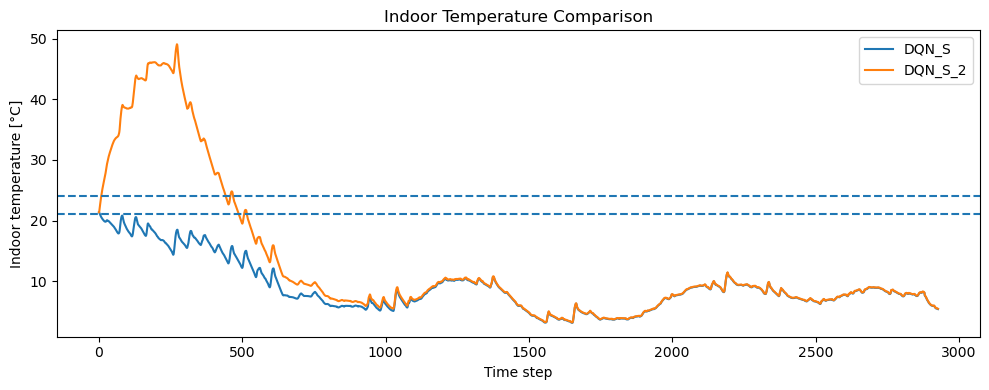

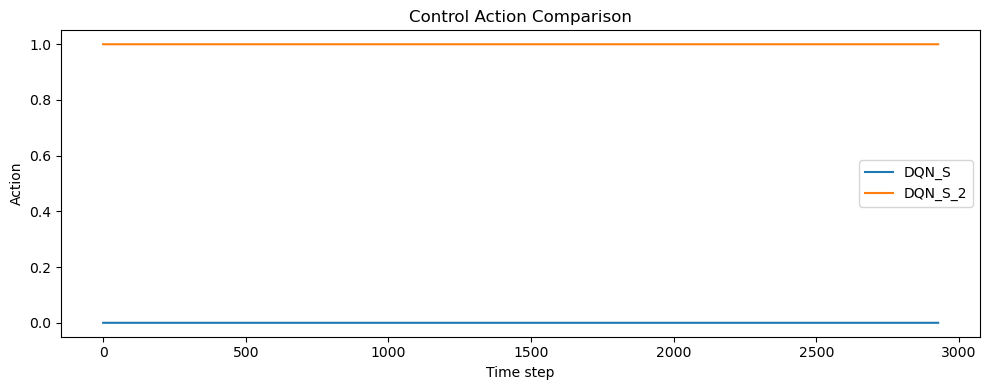

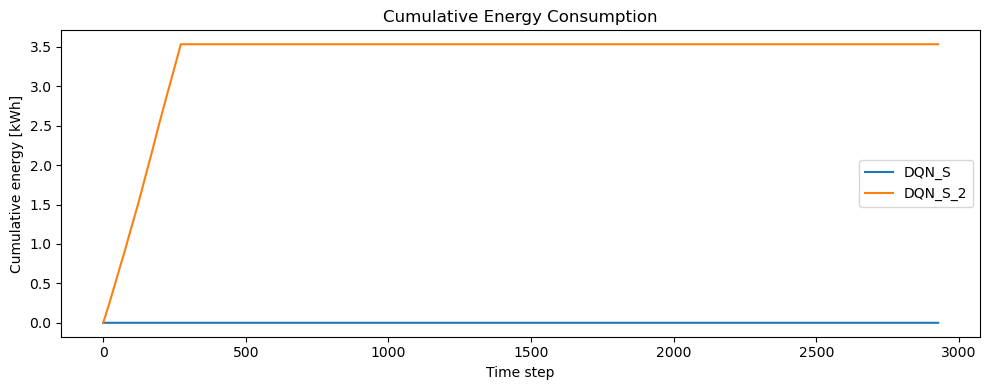

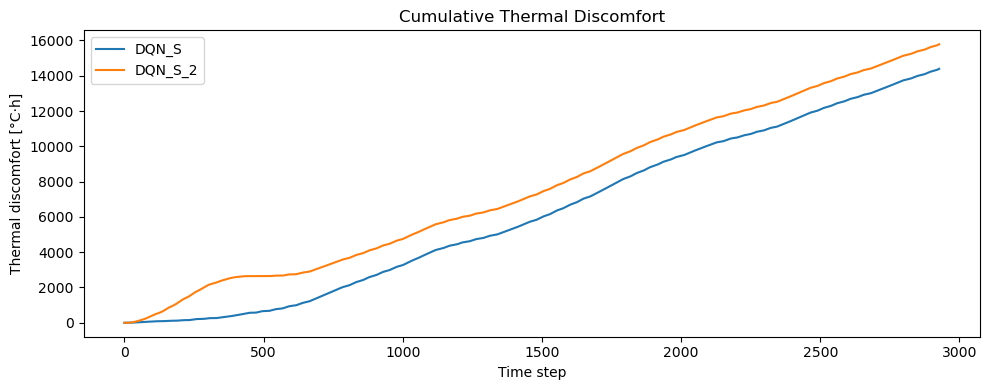


Controller Performance Summary
--------------------------------------------------
DQN_S           | Energy:     0.00 kWh | Discomfort: 14391.99 °C·h
DQN_S_2         | Energy:     3.53 kWh | Discomfort: 15782.87 °C·h


In [30]:
plot_indoor_temperature(dfs)
plot_actions(dfs)
plot_cumulative_energy(dfs)
plot_cumulative_discomfort(dfs)

print_summary_table(dfs)